# Deep Fake Classifier



<h2><font color="#004D7F" size=6> Libraries to be used </font> </h2>

---


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from sklearn.utils import shuffle
import matplotlib
import seaborn as sns
import sklearn
import PIL
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import metrics, layers, Model, models
from tensorflow.keras.applications import ResNet50V2, MobileNetV2, InceptionV3, DenseNet121, VGG19
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.models import load_model
from tensorflow.keras.layers import  Input, Conv2D, MaxPooling2D,GlobalMaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Activation, MaxPool2D, AvgPool2D, Dropout, Conv1D,BatchNormalization, MaxPooling1D
import matplotlib.cm as cm
from IPython.display import Image, display
import keras

In [15]:
seed = 5

<h2><font color="#004D7F" size=6> Import the data</font></h2>

---

<font color="#004D7F" size=3>   We import the resized images and its labels and keep it into a pandas data frame  </font>

In [16]:
dir = "data\\"

label = []
path = []

for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        label.append(os.path.split(dirname)[1])
        path.append(os.path.join(dirname,filename))

df = pd.DataFrame(columns=['path','label'])
df['path'] = path
df['label'] = label

# We shuffle the data because the first X elements belongs to a class and the left belongs to the other
df = shuffle(df)
df

,path,label
525,data\fake\fake_572.jpg,fake
691,data\fake\fake_91.jpg,fake
14,data\fake\fake_111.jpg,fake
804,data\real\real_193.jpg,real
755,data\real\real_149.jpg,real
...,...,...
319,data\fake\fake_387.jpg,fake
127,data\fake\fake_213.jpg,fake
1218,data\real\real_566.jpg,real
1086,data\real\real_447.jpg,real


<h2><font color="#004D7F" size=6> Class distribution</font></h2>

---

<font color="#004D7F" size=3> </font>

In [17]:
df["label"] = df["label"].astype("category")

print(f"Total cases     : {df.shape[0]}\n")
print(f"Real photos : {df['label'].value_counts().real} => {round(df['label'].value_counts().real/len(df)*100,2)}%")
print(f"Fake photos : {df['label'].value_counts().fake} => {round(df['label'].value_counts().fake/len(df)*100,2)}%")

Total cases     : 1289

Real photos : 589 => 45.69%
Fake photos : 700 => 54.31%


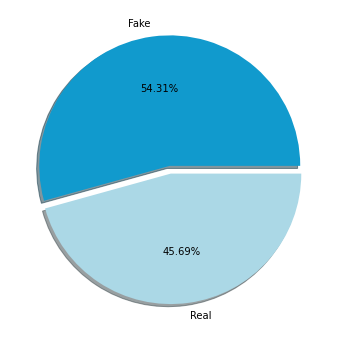

In [18]:
data = [df['label'].value_counts()[0], df['label'].value_counts()[1]]
labels = ["Fake","Real"]
colors = ['#119ACD', '#ABD8E6']
plt.figure(figsize=(10,6))
plt.pie(data, labels=labels, colors = colors, autopct='%.2f%%', shadow=True, explode = [0.03,0.03])
plt.show()

# Check some images

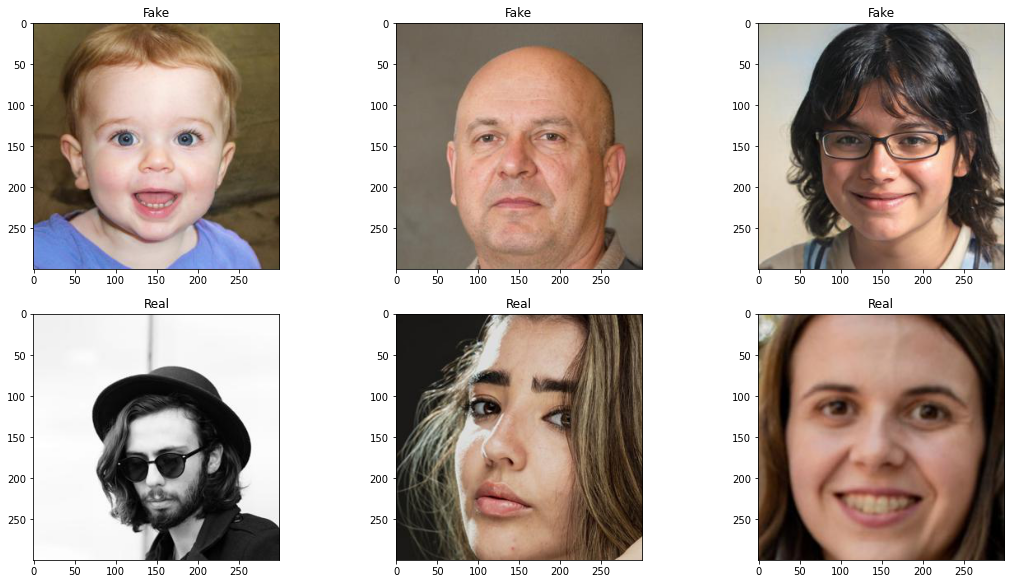

In [19]:
fake_to_print = [df["path"].iloc[img] for img in range(len(df["path"])) if df["label"].iloc[img]=="fake"][:3]
real_to_print = [df["path"].iloc[img] for img in range(len(df["path"])) if df["label"].iloc[img]=="real"][:3]
to_print = fake_to_print + real_to_print

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,8), constrained_layout=True)
ax = ax.flatten()
j = 0

for i in to_print:
    ax[j].imshow(plt.imread(i))
    if 'fake' in i:
        ax[j].set_title("Fake")
    else:
        ax[j].set_title("Real")
    j+=1

<h2><font color="#004D7F" size=6> Train and test split     </font></h2>

---


In [20]:
test_size = 0.3
X_train, X_test = train_test_split(df, test_size=test_size, shuffle = True, random_state = seed)
print(f"Train set size: {X_train.shape[0]} images\nTest set size : {X_test.shape[0]} images")

Train set size: 902 images
Test set size : 387 images


<h2><font color="#004D7F" size=6> Data preprocessing    </font></h2>

---

<font color="#004D7F" size=3>  </font>

In [21]:
trainGen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.3, )
testGen =ImageDataGenerator(preprocessing_function = preprocess_input)

In [22]:
# Batch sizes for training, validation and testing
train_bs = 10
val_bs = 10
test_bs = 10

In [23]:
X_train_img = trainGen.flow_from_dataframe(dataframe=X_train, x_col='path', y_col='label',class_mode='categorical', subset='training', color_mode='rgb', batch_size=train_bs, seed=seed)
X_val_img = trainGen.flow_from_dataframe(dataframe=X_train, x_col='path', y_col='label',class_mode='categorical', subset='validation', color_mode='rgb', batch_size=val_bs, seed=seed)
X_test_img = testGen.flow_from_dataframe(dataframe=X_test, x_col='path', y_col='label',class_mode='categorical', color_mode='rgb', batch_size=test_bs, shuffle=False, seed=seed)

Found 632 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.
Found 387 validated image filenames belonging to 2 classes.


In [24]:
print(f"Image shape: {X_test_img[0][0].shape}")
image_shape = X_test_img[0][0].shape[1:]
print(f"Class indices: {X_train_img.class_indices}")

Image shape: (10, 256, 256, 3)
Class indices: {'fake': 0, 'real': 1}


<h2><font color="#004D7F" size=6> CNN Model
    </font></h2>
    
---


<font color="#004D7F" size=3> I will use a pre-trained neural network (a MobileNetV2), which will help the model to achieve better results in less epochs. Even, it could let the model achieve better results than it could ever gets without one

The hyperparameters selected were choosed by try and failure. They fit very good, but surely there is a better set of hyperparameters to choose.
</font>


In [26]:
pre_trained = MobileNetV2(include_top=False, pooling='avg', input_shape=image_shape, classes=2)
pre_trained.trainable = False

In [27]:
# Hyperparameters 

batch_size = 16
learning_rate = 0.001
epochs = 15
dropout = 0.33

In [28]:
inp_model = pre_trained.input

x = Conv2D(64, (3, 3), activation='relu', padding='same')(inp_model)
#x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x=Flatten()(pre_trained.output)
x = Dense(128, activation='relu')(pre_trained.output) 
x = Dropout(dropout)(x)
x = Dense(64, activation='relu')(x) 
x = Dropout(dropout)(x)                          
x = Dense(32, activation='relu')(x)           
output = Dense(2, activation='softmax')(x)
model = Model(inputs=inp_model, outputs=output)
optimizer = keras.optimizers.Adamax(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer= optimizer,
              metrics=['accuracy', metrics.Recall(), metrics.CategoricalAccuracy()])

In [29]:
results = model.fit(X_train_img,
                    epochs= epochs,
                    batch_size = batch_size,
                    validation_data=X_val_img)

Epoch 1/15
64/64 [==============================] - 22s 350ms/step - loss: 0.5516 - accuracy: 0.7104 - recall: 0.7104 - categorical_accuracy: 0.7104 - val_loss: 0.2940 - val_accuracy: 0.8963 - val_recall: 0.8963 - val_categorical_accuracy: 0.8963
Epoch 2/15
64/64 [==============================] - 25s 388ms/step - loss: 0.3583 - accuracy: 0.8497 - recall: 0.8497 - categorical_accuracy: 0.8497 - val_loss: 0.2328 - val_accuracy: 0.9148 - val_recall: 0.9148 - val_categorical_accuracy: 0.9148
Epoch 3/15
64/64 [==============================] - 25s 383ms/step - loss: 0.2867 - accuracy: 0.8877 - recall: 0.8877 - categorical_accuracy: 0.8877 - val_loss: 0.1898 - val_accuracy: 0.9370 - val_recall: 0.9370 - val_categorical_accuracy: 0.9370
Epoch 4/15
64/64 [==============================] - 28s 437ms/step - loss: 0.2181 - accuracy: 0.9193 - recall: 0.9193 - categorical_accuracy: 0.9193 - val_loss: 0.1602 - val_accuracy: 0.9296 - val_recall: 0.9296 - val_categorical_accuracy: 0.9296
Epoch 5/15
6

In [30]:
#model.save("model.h5")
#model = keras.models.load_model("model.h5")

In [31]:
result = pd.DataFrame(results.history)

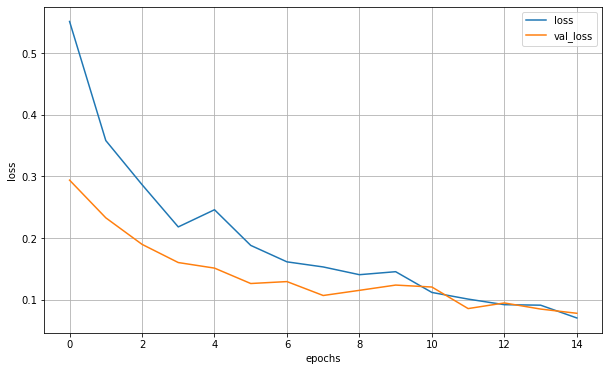

In [32]:
result[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

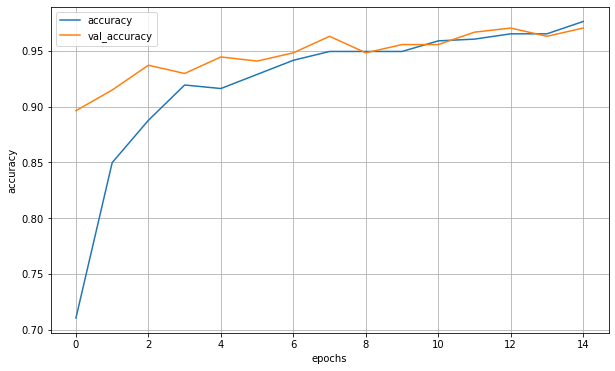

In [33]:
result[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

<h2><font color="#004D7F" size=6>Predictions and results</font></h2>

---


In [34]:
# Here I created a copy of the original dataset, where model predictions are added up for the next step; the evaluation.

preds = model.predict(X_test_img)
preds = np.argmax(preds, axis=1)   
preds_df = X_test.copy()  

In [35]:
labels = {}
for l,v in X_test_img.class_indices.items():
    labels.update({v:l})
preds_df['preds'] = preds
preds_df['preds'] = preds_df['preds'].apply(lambda x: labels[x])


Batch Size = 16
Learning Rate = 0.001
Epochs = 15
Training Batch Size = 10
Validation Batch Size = 10
Test Batch Size = 10
Dropout rate = 0.33
Optimizer = Adam

              precision    recall  f1-score   support

        fake       0.98      0.96      0.97       211
        real       0.95      0.97      0.96       176

    accuracy                           0.96       387
   macro avg       0.96      0.96      0.96       387
weighted avg       0.96      0.96      0.96       387

Accuracy Score: 96.38%



<AxesSubplot:xlabel='preds', ylabel='label'>

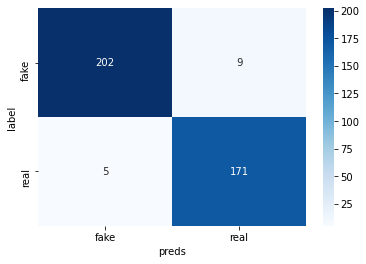

In [36]:
# Here are the results. The hyperparameters are printed in the first place, so you can take a screenshot of the results
# and its hyperparams in case you want to take this model and experiment with it. Next there are presented the 
# classification report, which tells the most used metrics, like accuracy and precision, and finally, the confussion matrix

print(f"\nBatch Size = {batch_size}\n"
          f"Learning Rate = {learning_rate}\n"
          f"Epochs = {epochs}\n"
          f"Training Batch Size = {train_bs}\n"
          f"Validation Batch Size = {val_bs}\n"
          f"Test Batch Size = {test_bs}\n"
          f"Dropout rate = {dropout}\n"
          f"Optimizer = Adam\n")

print(classification_report(preds_df["label"], preds_df["preds"]))
print(f"Accuracy Score: {round(accuracy_score(preds_df['label'],preds_df['preds'])*100,2)}%\n")
cf_matrix = pd.crosstab(preds_df["label"], preds_df["preds"])
sns.heatmap(cf_matrix, annot=True, fmt='2d', cmap = "Blues",)